In [2]:
import numpy
import matplotlib
from matplotlib import pyplot as plt
import pandas
%matplotlib inline

In [3]:
numu = numpy.load('sbnd_dl_numuCC_larcv_preprocessed_val.npy')
nc   = numpy.load('sbnd_dl_NC_larcv_preprocessed_val.npy')
nue  = numpy.load('sbnd_dl_nueCC_larcv_preprocessed_val.npy')

In [4]:
# Make sure the labels are correct in all files:
print numpy.unique(numu['neut'], return_counts=True)
print numpy.unique(nue['neut'])
print numpy.unique(nc['neut'])

(array([0, 1], dtype=int8), array([  149, 15797]))
[0]
[2]


Some of the events in the numu file should not be there!

In [5]:
print numpy.where(numu['neut'] == 0)


(array([  196,   497,   652,   737,  1064,  1146,  1181,  1217,  1286,
        1782,  1937,  2082,  2147,  2161,  2317,  2472,  2521,  2665,
        2675,  2711,  2856,  3338,  3371,  3388,  3483,  3546,  3570,
        3628,  3764,  3838,  4163,  4248,  4270,  4374,  4402,  4445,
        4512,  4516,  4762,  4882,  4896,  4919,  4953,  5163,  5180,
        5190,  5309,  5580,  5646,  5672,  5920,  6249,  6297,  6335,
        6410,  6425,  6760,  6891,  7156,  7468,  7622,  7693,  7728,
        7939,  8012,  8060,  8072,  8164,  8184,  8236,  8334,  8456,
        8476,  8741,  8856,  8963,  8973,  9030,  9043,  9074,  9202,
        9272,  9325,  9332,  9407,  9847,  9980, 10173, 10187, 10466,
       10507, 10543, 10555, 10574, 10607, 10631, 10672, 10702, 10721,
       10888, 11015, 11218, 11266, 11556, 11559, 11584, 11615, 11655,
       11785, 12089, 12105, 12230, 12270, 12273, 12295, 12446, 12449,
       12509, 12549, 12764, 12916, 12939, 13043, 13060, 13142, 13247,
       13388, 13512

The easiest solution is to just merge everything together:


In [6]:
df = pandas.DataFrame.from_records(nue)
_temp_df1  = pandas.DataFrame.from_records(numu)
_temp_df2  = pandas.DataFrame.from_records(nc)
df = pandas.concat([df, _temp_df1, _temp_df2])
print df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57116 entries, 0 to 26775
Data columns (total 26 columns):
prot1_score3d    57116 non-null float64
energy           57116 non-null float32
prot2_score2d    57116 non-null float64
neut             57116 non-null int8
chpi0_score2d    57116 non-null float64
nue_score2d      57116 non-null float64
ntpi1_score3d    57116 non-null float64
chpi1_score3d    57116 non-null float64
numu_score2d     57116 non-null float64
prot             57116 non-null int8
chpi1_score2d    57116 non-null float64
prot0_score2d    57116 non-null float64
nc_score2d       57116 non-null float64
ntpi0_score2d    57116 non-null float64
neutpi           57116 non-null int8
chrpi            57116 non-null int8
prot2_score3d    57116 non-null float64
chpi0_score3d    57116 non-null float64
prot1_score2d    57116 non-null float64
nue_score3d      57116 non-null float64
ntpi1_score2d    57116 non-null float64
numu_score3d     57116 non-null float64
nc_score3d       57116 

Fixed.

This code adds a prediction for each individual classifier that can be compared directly to the true labels:

In [7]:
df['neut_pred_2d']   = numpy.argmax(df[['nue_score2d',   'numu_score2d',  'nc_score2d']].values,    axis=1)
df['prot_pred_2d']   = numpy.argmax(df[['prot0_score2d', 'prot1_score2d', 'prot2_score2d']].values, axis=1)
df['chrpi_pred_2d']  = numpy.argmax(df[['chpi0_score2d', 'chpi1_score2d']].values,                  axis=1)
df['neutpi_pred_2d'] = numpy.argmax(df[['ntpi0_score2d', 'ntpi1_score2d']].values,                  axis=1)
df['neut_pred_3d']   = numpy.argmax(df[['nue_score3d',   'numu_score3d',  'nc_score3d']].values,    axis=1)
df['prot_pred_3d']   = numpy.argmax(df[['prot0_score3d', 'prot1_score3d', 'prot2_score3d']].values, axis=1)
df['chrpi_pred_3d']  = numpy.argmax(df[['chpi0_score3d', 'chpi1_score3d']].values,                  axis=1)
df['neutpi_pred_3d'] = numpy.argmax(df[['ntpi0_score3d', 'ntpi1_score3d']].values,                  axis=1)
# numpy.argmax(df[['nue_score2d', 'numu_score2d', 'nc_score2d']].values, axis=1)


### Accuracies

There are a total of 36 accuracies.  I will compute the confusion matrix between all 36 categories, which can then be distilled to any particular sub selection

In [8]:
def confusion_matrix(df, mode):
    if mode not in ['2d','3d']:
        raise Exception()
        
    true_selection_query = "neut=={neut} & chrpi=={cp} & neutpi=={np} & prot =={prot}"
    if mode == '2d':
        pred_selection_query = "neut_pred_2d=={neut} & chrpi_pred_2d=={cp} & neutpi_pred_2d=={np} & prot_pred_2d =={prot}"
    else:
        pred_selection_query = "neut_pred_3d=={neut} & chrpi_pred_3d=={cp} & neutpi_pred_3d=={np} & prot_pred_3d =={prot}"
        
    confusion_matrix = numpy.zeros((36,36))
    
    key = []
    
    # Loop over all categories, and compute the accuracies and confusion matrices
    for neut in [0,1,2]:
        for prot in [0,1,2]:
            for chrpi in [0,1]:
                for neutpi in [0,1]:
                    key.append({'neut': neut, 'cp' : chrpi, 'np': neutpi, 'prot':prot})
                    
    for true_index in range(len(key)):
        true_query = true_selection_query.format(**key[true_index])
        true_df = df.query(true_query)
        for pred_index in range(len(key)):
            pred_query = pred_selection_query.format(**key[pred_index])
            n_events = true_df.query(pred_query).shape[0]
            confusion_matrix[true_index][pred_index] = n_events
    
    return confusion_matrix

In [9]:
true_selection_query = "neut=={neut} & chrpi=={cp} & neutpi=={np} & prot =={prot}"
cm_2d = confusion_matrix(df, '2d')
cm_3d = confusion_matrix(df, '3d')


Compute the numu accuracies:

In [11]:
numu_df = df.query('neut==1')
true_numu = numu_df.shape[0]
selected_numu_2d = numu_df.query('neut_pred_2d==1').shape[0]
selected_numu_3d = numu_df.query('neut_pred_3d==1').shape[0]
print true_numu
print selected_numu_2d
print selected_numu_3d

15797
14722
14406


In [27]:
# Compute the single classifier accuracies:

print "Neutrino Accuracies: "
print "--2D:"
print "----nue:  "  + str(1.0*df.query("neut==0 & neut_pred_2d==0").shape[0] / df.query("neut==0").shape[0])
print "----numu: " + str(1.0*df.query("neut==1 & neut_pred_2d==1").shape[0] / df.query("neut==1").shape[0])
print "----nc:   " + str(1.0*df.query("neut==2 & neut_pred_2d==2").shape[0] / df.query("neut==2").shape[0])
print "--3D:"
print "----nue:  "  + str(1.0*df.query("neut==0 & neut_pred_3d==0").shape[0] / df.query("neut==0").shape[0])
print "----numu: " + str(1.0*df.query("neut==1 & neut_pred_3d==1").shape[0] / df.query("neut==1").shape[0])
print "----nc:   " + str(1.0*df.query("neut==2 & neut_pred_3d==2").shape[0] / df.query("neut==2").shape[0])
print "============================================="
print "Proton Accuracies: "
print "--2D:"
print "----0:  " + str(1.0*df.query("prot==0 & prot_pred_2d==0").shape[0] / df.query("prot==0").shape[0])
print "----1:  " + str(1.0*df.query("prot==1 & prot_pred_2d==1").shape[0] / df.query("prot==1").shape[0])
print "----2+: " + str(1.0*df.query("prot==2 & prot_pred_2d==2").shape[0] / df.query("prot==2").shape[0])
print "--3D:"
print "----0:  "  + str(1.0*df.query("prot==0 & prot_pred_3d==0").shape[0] / df.query("prot==0").shape[0])
print "----1:  " + str(1.0*df.query("prot==1 & prot_pred_3d==1").shape[0] / df.query("prot==1").shape[0])
print "----2+: " + str(1.0*df.query("prot==2 & prot_pred_3d==2").shape[0] / df.query("prot==2").shape[0])
print "============================================="
print "Charged Pion Accuracies: "
print "--2D:"
print "----0:  " + str(1.0*df.query("chrpi==0 & chrpi_pred_2d==0").shape[0] / df.query("chrpi==0").shape[0])
print "----1+: " + str(1.0*df.query("chrpi==1 & chrpi_pred_2d==1").shape[0] / df.query("chrpi==1").shape[0])
print "--3D:"
print "----0:  "  + str(1.0*df.query("chrpi==0 & chrpi_pred_3d==0").shape[0] / df.query("chrpi==0").shape[0])
print "----1+: "  + str(1.0*df.query("chrpi==1 & chrpi_pred_3d==1").shape[0] / df.query("chrpi==1").shape[0])
print "============================================="
print "Neutral Pion Accuracies: "
print "--2D:"
print "----0:  " + str(1.0*df.query("neutpi==0 & neutpi_pred_2d==0").shape[0] / df.query("neutpi==0").shape[0])
print "----1+: " + str(1.0*df.query("neutpi==1 & neutpi_pred_2d==1").shape[0] / df.query("neutpi==1").shape[0])
print "--3D:"
print "----0:  "  + str(1.0*df.query("neutpi==0 & neutpi_pred_3d==0").shape[0] / df.query("neutpi==0").shape[0])
print "----1+: "  + str(1.0*df.query("neutpi==1 & neutpi_pred_3d==1").shape[0] / df.query("neutpi==1").shape[0])


Neutrino Accuracies: 
--2D:
----nue:  0.949047651791
----numu: 0.93194910426
----nc:   0.858567373768
--3D:
----nue:  0.950422883862
----numu: 0.911945306071
----nc:   0.914923812369
Proton Accuracies: 
--2D:
----0:  0.93272229648
----1:  0.904346224678
----2+: 0.883970536654
--3D:
----0:  0.91509133728
----1:  0.882651933702
----2+: 0.87520168362
Charged Pion Accuracies: 
--2D:
----0:  0.955641208448
----1+: 0.753106605625
--3D:
----0:  0.958493004189
----1+: 0.778041203401
Neutral Pion Accuracies: 
--2D:
----0:  0.988470358417
----1+: 0.816067864271
--3D:
----0:  0.980720231017
----1+: 0.884231536926


In [125]:
# print the confusion matrix:
 
key = []

# Loop over all categories, and compute the accuracies and confusion matrices
for neut in [0,1,2]:
    for prot in [0,1,2]:
        for chrpi in [0,1]:
            for neutpi in [0,1]:
                key.append({'neut': neut, 'cp' : chrpi, 'np': neutpi, 'prot':prot})
                
with open("confusion_matrix_3d.csv", 'w') as _out:
    for name in key[i].keys():
        _out.write(name)
        _out.write('\t')
    _out.write('\n')
    for i in range(len(key)):
        for name in key[i].keys():
            _out.write(str(key[i][name]))
            _out.write('\t')
        for j in range(len(key)):
            _out.write(str(int(cm_3d[i][j])))
            _out.write('\t')
        _out.write('\n')

with open("confusion_matrix_2d.csv", 'w') as _out:
    for name in key[i].keys():
        _out.write(name)
        _out.write('\t')
    _out.write('\n')
    for i in range(len(key)):
        for name in key[i].keys():
            _out.write(str(key[i][name]))
            _out.write('\t')
        for j in range(len(key)):
            _out.write(str(int(cm_2d[i][j])))
            _out.write('\t')
        _out.write('\n')

Make a selection of events for 2d and 3d.  Events need to be properly weighted.  Compute the weights here:

In [8]:
numu_pot_per_event = 1.8339e14
nue_pot_per_event  = 1.99e16
nc_pot_per_event   = 5.19e14


In [9]:
event_labels, event_counts = numpy.unique(df['neut'], return_counts=True)
print event_labels, event_counts

[0 1 2] [14543 15797 26776]


In [10]:
nue_total_pot = nue_pot_per_event * event_counts[0]
numu_total_pot = numu_pot_per_event * event_counts[1]
nc_total_pot = nc_pot_per_event * event_counts[2]

In [11]:
pot_normalization = 1.e18
nue_event_weight =  pot_normalization / nue_total_pot
numu_event_weight =  pot_normalization / numu_total_pot
nc_event_weight =  pot_normalization / nc_total_pot

In [12]:
print nue_event_weight
print numu_event_weight
print nc_event_weight

0.00345535696083
0.345183264233
0.0719593021214


In [13]:
# Add a weights column to the dataframe:
df['weight'] = 0
df.loc[df['neut'] == 0,'weight'] = nue_event_weight
df.loc[df['neut'] == 1,'weight'] = numu_event_weight
df.loc[df['neut'] == 2,'weight'] = nc_event_weight

# To check the weights are correct, let's print out the number of total weighted events:
print "Total number of nue events: " + str(df.query('neut==0')['weight'].sum())
print "Total number of numu events: " + str(df.query('neut==1')['weight'].sum())
print "Total number of NC events: " + str(df.query('neut==2')['weight'].sum())


Total number of nue events: 50.25125628140705
Total number of numu events: 5452.860025083155
Total number of NC events: 1926.7822736030826


Now, make a distribution of all components of the beam, with no cuts, and various categories broken out.  There are a total of 36 categories which is a bit heavy.  So I will use just the overall neutrino flavors:

In [14]:
def plot_selected_events(df, selections = [], labels = [], colors = [], target='energy', bins=None, savepath=None):
    
    if bins is None:
        bins = numpy.asarray([0,0.2, 0.4,0.6,0.8,1.0,1.2,1.5,2.0,2.5,3.5, 5.0])
    bin_centers = 0.5*(bins[1:] + bins[0:-1])
    bin_widths =  bins[1:] - bins[:-1]
    
    if len(selections) == 0 or len(selections) != len(labels) or len(selections) != len(colors):
        print "Using default selection and labels"
        selections = ['neut==0', 'neut==1', 'neut==2']
        labels = [r'$\nu_e$ CC', r'$\nu_\nu$ CC', 'NC']
        colors = ['navy', 'darkgreen', 'firebrick']

    values = []
    for i in range(len(selections)):
        sub_df = df.query(selections[i])
        energy = sub_df[target]
        weight = sub_df['weight']

        temp_values, _ = numpy.histogram(energy, bins=bins, weights=weight)
        temp_values /= (bin_widths / 0.2)
        values.append(temp_values)
    #     print "{}: {}".format(i, numpy.sum(values))

    
    # Make a bar chart to show the values:
    fig = plt.figure(figsize=(16.,9))
    plt.grid(True)

    bottoms = numpy.zeros(shape=values[0].shape)

    for i in range(len(selections)):
        plt.bar(bin_centers, values[i],align='center', bottom=bottoms, width=bin_widths,
               color=colors[i], label=labels[i])
        bottoms += values[i]
        # This is how you plot a normal histogram in matplotlib without it fucking up the bin locations:
        plt.plot(bin_centers + bin_widths*0.5, bottoms, color='black',
                 ls='steps')
        
    plt.xlabel("True Energy [GeV]", fontsize=25)
    plt.ylabel("Events / 200 MeV", fontsize=25)

    plt.xlim(0,5)

    ax = plt.gca()
    ax.set_axisbelow(True)
    for axis in [ax.xaxis, ax.yaxis]:
        for tick in axis.get_major_ticks():
            tick.label.set_fontsize(20)



    plt.legend(fontsize=25)
    if savepath is not None:
        plt.savefig(savepath)
        
    plt.show()
    

Using default selection and labels


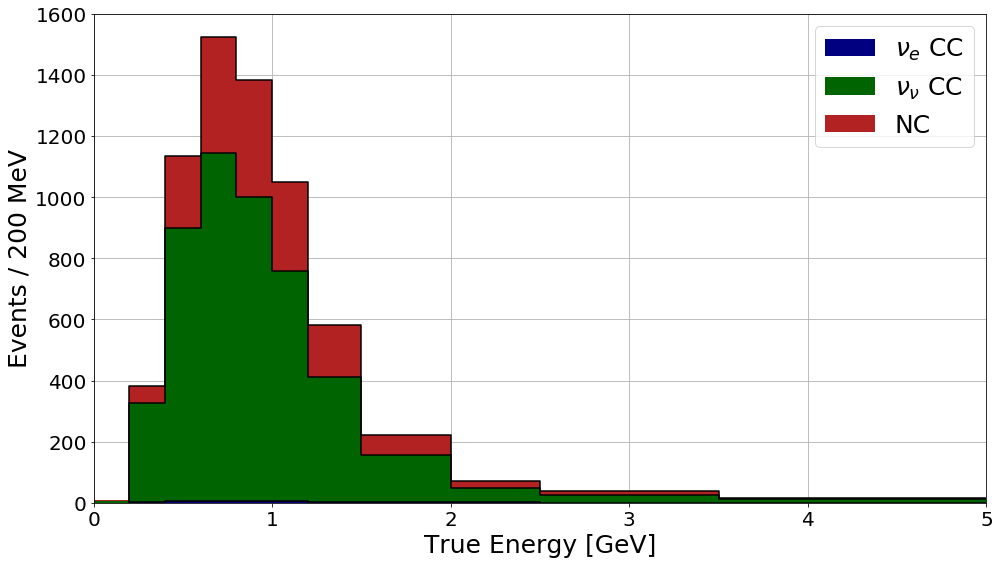

In [15]:
plot_selected_events(df)

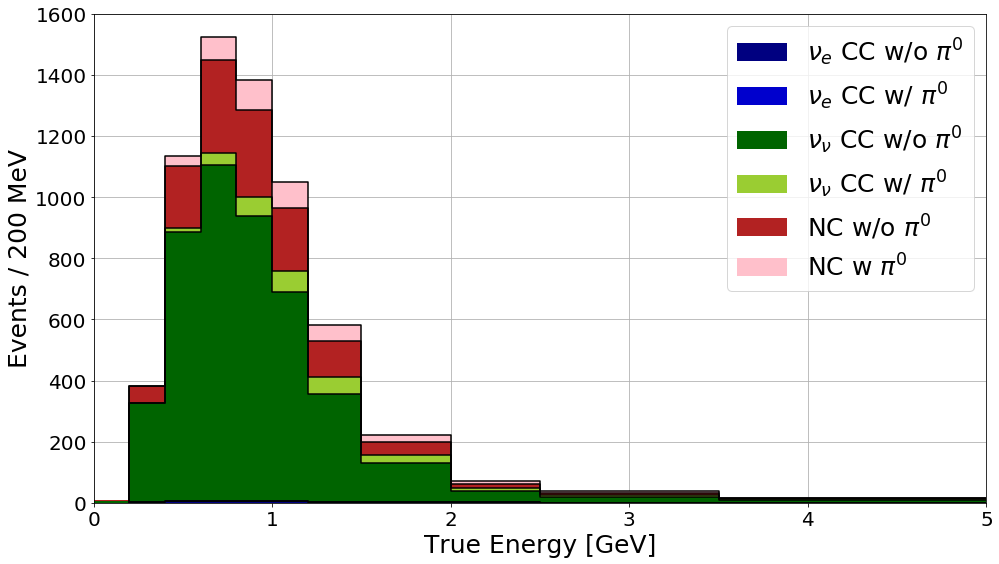

In [16]:
# Break things down further to test the plotting functionality:
selection = ['neut==0 & neutpi ==0',
             'neut==0 & neutpi ==1',
             'neut==1 & neutpi ==0', 
             'neut==1 & neutpi ==1', 
             'neut==2 & neutpi ==0',
             'neut==2 & neutpi ==1',
            ]
labels = [r'$\nu_e$ CC w/o $\pi^0$',
          r'$\nu_e$ CC w/ $\pi^0$',
          r'$\nu_\nu$ CC w/o $\pi^0$', 
          r'$\nu_\nu$ CC w/ $\pi^0$', 
          'NC w/o $\pi^0$',
          'NC w $\pi^0$',
         ]
colors = ['navy',
          'mediumblue',
          'darkgreen', 
          'yellowgreen',
          'firebrick',
          'pink',
         ]
plot_selected_events(df, selections = selection, labels = labels, colors = colors)


That looks right.

# Electron Neutrino Selection

Use cuts to select electron neutrinos and reject numu and NC events.

### ROC Curves for $\nu_e$ and $\nu_\mu$ selections

Compute the efficiency and purity as a function of varying cuts:

In [20]:
def compute_purity_and_eff_2d_3d(df, 
                                 true_signal_selection, 
                                 selection_2d_template, 
                                 selection_3d_template, 
                                 cut_values):

    eff_2d = []
    purity_2d = []
    
    eff_3d = []
    purity_3d = []


    # Get the df of true events:
    true_events = df.query(true_signal_selection)

#     print "Number of true events: " + str(true_events.shape[0])
    
    for cut_value in cut_values:
        # We can ask the efficiency by selecting agains the true events
        # We can find the purity by selecting against the full selection, and then comparing true selection

        selected_true_events_2d = true_events.query(selection_2d_template.format(cut_value))
            
#         print "Number of events selected by 2D: " + str(selected_true_events_2d.shape[0])
            
        # The total efficiency is the number of selected true events divided by the total number of true events
        n_selected_2d = selected_true_events_2d.shape[0]
        n_true_2d = true_events.shape[0]
    
#         print "2D Efficiency: " + str(1.0 * n_selected_2d / n_true_2d)
    
        eff_2d.append(1.0 * n_selected_2d / n_true_2d)
    

        selected_true_events_3d = true_events.query(selection_3d_template.format(cut_value))
            
#         print "Number of events selected by 3D: " + str(selected_true_events_3d.shape[0])

        # The total efficiency is the number of selected true events divided by the total number of true events
        n_selected_3d = selected_true_events_3d.shape[0]
        n_true_3d = true_events.shape[0]
    
        eff_3d.append(1.0 * n_selected_3d / n_true_3d)
    
#         print "3D Efficiency: " + str(1.0 * n_selected_3d / n_true_3d)
    
        # Compute the purity by asking for all selected events, and then seeing how many of those are true
        selected_events_2d = df.query(selection_2d_template.format(cut_value))
            
        selected_events_3d = df.query(selection_3d_template.format(cut_value))
            
        n_selected_events_2d = selected_events_2d['weight'].sum()
        n_selected_events_3d = selected_events_3d['weight'].sum()
        
#         print "N Selected Events 2d: " + str(n_selected_events_2d)
#         print "N Selected Events 3d: " + str(n_selected_events_3d)
        
        n_true_selected_2d = selected_events_2d.query(true_signal_selection)['weight'].sum()
        n_true_selected_3d = selected_events_3d.query(true_signal_selection)['weight'].sum()

        if n_true_selected_2d != 0:
            purity_2d.append(1.0 * n_true_selected_2d / n_selected_events_2d)
        else:
            purity_2d.append(0)

        if n_true_selected_3d != 0:
            purity_3d.append(1.0 * n_true_selected_3d / n_selected_events_3d)
        else:
            purity_3d.append(0)
    

    return eff_2d, eff_3d, purity_2d, purity_3d
    

In [91]:
true_signal_selection = "neut == 0"
selection_2d_template = "nue_score2d >= {}"
selection_3d_template = "nue_score3d >= {}"

cut_values = numpy.concatenate( (numpy.linspace(0.0, 0.99, 100),  numpy.geomspace(0.99, 0.999999, 100)) )
# cut_values = [0.99999]
eff_2d, eff_3d, purity_2d, purity_3d = compute_purity_and_eff_2d_3d(df, 
                                                                    true_signal_selection, 
                                                                    selection_2d_template, 
                                                                    selection_3d_template, 
                                                                    cut_values)




In [93]:
#Here we find the cut values that give just over XX% efficiency:
eff_target = 0.8
eff_threshold_2d = numpy.asarray(eff_2d) - eff_target
eff_threshold_2d[eff_threshold_2d < 0] = 999.0
eff_min_index_2d =  numpy.argmin(eff_threshold_2d)
eff_threshold_3d = numpy.asarray(eff_3d) - eff_target
eff_threshold_3d[eff_threshold_3d < 0] = 999.0
eff_min_index_3d = numpy.argmin(eff_threshold_3d)
print "Cut value for {}% efficiency: ".format(eff_target*100)
print "  {} (2D)".format(cut_values[eff_min_index_2d])
print "  {} (3D)".format(cut_values[eff_min_index_3d])

#Here we find the cut values that give just over XX% efficiency:
purity_target = 0.8
purity_threshold_2d = numpy.asarray(purity_2d) - purity_target
purity_threshold_2d[purity_threshold_2d < 0] = 999.0
purity_min_index_2d =  numpy.argmin(purity_threshold_2d)
purity_threshold_3d = numpy.asarray(purity_3d) - purity_target
purity_threshold_3d[purity_threshold_3d < 0] = 999.0
purity_min_index_3d = numpy.argmin(purity_threshold_3d)
print "Cut value for {}% purity: ".format(purity_target*100)
print "  {} (2D)".format(cut_values[purity_min_index_2d])
print "  {} (3D)".format(cut_values[purity_min_index_3d])



Cut value for 80.0% efficiency: 
  0.94 (2D)
  0.96 (3D)
Cut value for 80.0% purity: 
  0.999593049055 (2D)
  0.997970892568 (3D)


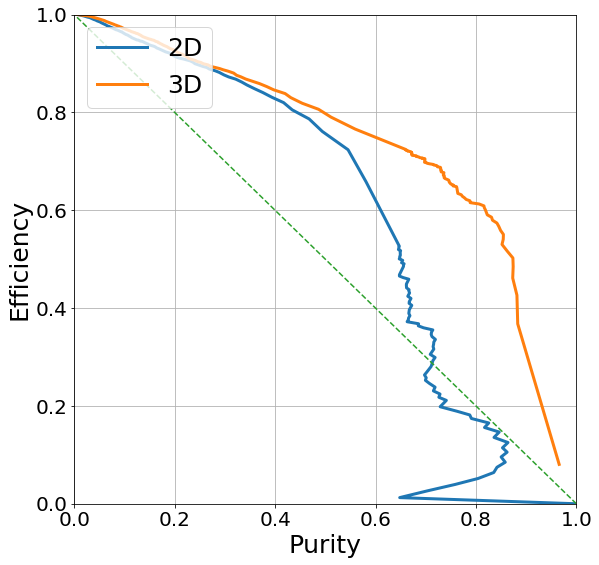

In [94]:

# Make the plot:
fig = plt.figure(figsize=(9,9))
plt.grid(True)
plt.plot(purity_2d,eff_2d,lw=3, label="2D")
plt.plot(purity_3d, eff_3d,lw=3, label="3D")
plt.plot([1,0], [0,1], ls='--')

plt.ylabel("Efficiency", fontsize=25)
plt.xlabel("Purity", fontsize=25)


plt.legend(fontsize=25, loc=2)

plt.xlim(0,1)
plt.ylim(0,1)
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(20)
plt.savefig("ROC_nueCC_inclusive.png")

## Event Distributions:

Plot the distributions of selected events:

In [17]:
# cuts_2d = "nue_score2d>={}".format(0.99)
cuts_2d = "nue_score2d>={}".format(cut_values[purity_min_index_2d])
selected_events_2d = df.query(cuts_2d)
# Break things down further to test the plotting functionality:
selection = ['neut==0 & neutpi ==0',
             'neut==0 & neutpi ==1',
             'neut==1 & neutpi ==0', 
             'neut==1 & neutpi ==1', 
             'neut==2 & neutpi ==0',
             'neut==2 & neutpi ==1',
            ]
labels = [r'$\nu_e$ CC w/o $\pi^0$',
          r'$\nu_e$ CC w/ $\pi^0$',
          r'$\nu_\nu$ CC w/o $\pi^0$', 
          r'$\nu_\nu$ CC w/ $\pi^0$', 
          'NC w/o $\pi^0$',
          'NC w $\pi^0$',
         ]
colors = ['navy',
          'mediumblue',
          'darkgreen', 
          'yellowgreen',
          'firebrick',
          'pink',
         ]
plot_selected_events(selected_events_2d, selections=selection, labels=labels, colors=colors, savepath="nue_inclusive_2d.png")

NameError: name 'cut_values' is not defined

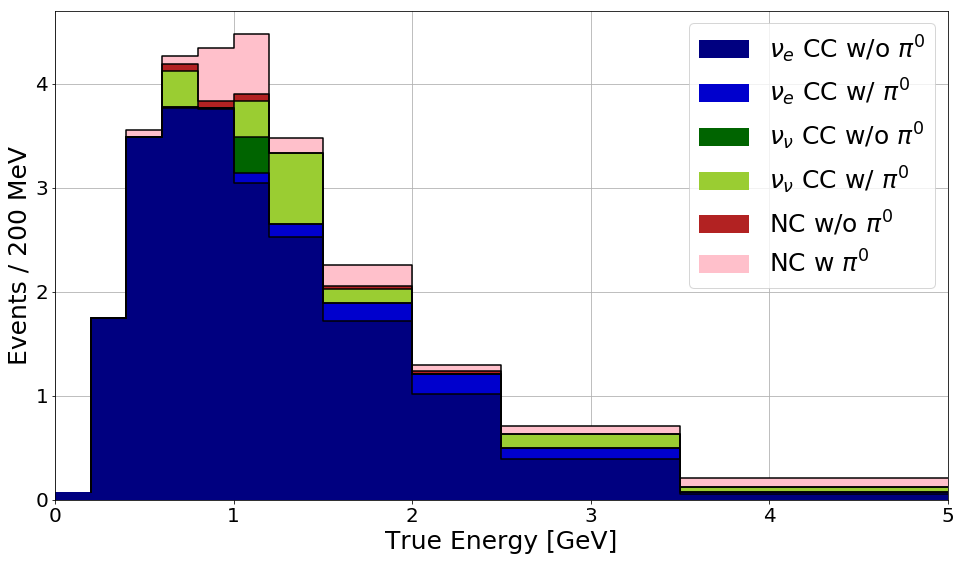

In [98]:
cuts_3d = "nue_score3d>={}".format(cut_values[purity_min_index_3d])
selection = ['neut==0 & neutpi ==0',
             'neut==0 & neutpi ==1',
             'neut==1 & neutpi ==0', 
             'neut==1 & neutpi ==1', 
             'neut==2 & neutpi ==0',
             'neut==2 & neutpi ==1',
            ]
labels = [r'$\nu_e$ CC w/o $\pi^0$',
          r'$\nu_e$ CC w/ $\pi^0$',
          r'$\nu_\nu$ CC w/o $\pi^0$', 
          r'$\nu_\nu$ CC w/ $\pi^0$', 
          'NC w/o $\pi^0$',
          'NC w $\pi^0$',
         ]
colors = ['navy',
          'mediumblue',
          'darkgreen', 
          'yellowgreen',
          'firebrick',
          'pink',
         ]
selected_events_3d = df.query(cuts_3d)
plot_selected_events(selected_events_3d, selections=selection, labels=labels, colors=colors, savepath="nueCC_inclusive_3d.png")

Make a function to plot the efficiency and purity of a selection

In [84]:
def measure_eff_and_purity(df, bins,
                           true_selection,
                           applied_selection,
                           target='energy'):
    
    bins = numpy.asarray(bins)
    bin_centers = 0.5*(bins[1:] + bins[0:-1])
    bin_widths =  bins[1:] - bins[:-1]
    
    # To do this, apply the true selection to the dataframe to get the real events
    # This allows to measure the efficiency
    
    # Then, apply the reco selection, and apply the true selection to that.
    # This allows to measure the purity.
    
    # This function allows to plot two dfs on the same plot, optionally.
    
    true_events = df.query(true_selection)
    selected_events = df.query(applied_selection)
    true_selected_events = selected_events.query(true_selection)
    
    eff = numpy.zeros(bins.shape)
    purity = numpy.zeros(bins.shape)
    
    true_values, _     = numpy.histogram(true_events[target], bins=bins, weights = true_events['weight'])
    selected_values, _ = numpy.histogram(selected_events[target], bins=bins, weights = selected_events['weight'])
    true_sel_values, _ = numpy.histogram(true_selected_events[target], bins=bins, weights = true_selected_events['weight'])
    
    efficiency = true_sel_values / true_values
    purity = true_sel_values / selected_values
    
    return efficiency, purity
    

In [85]:
bins = numpy.asarray([0, 0.4,0.6,0.8,1.0,1.2,1.5,2.0,2.5,3.5, 5.0])
bins_high_res = numpy.asarray([0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.2,1.5,2.0,2.5,3.5, 5.0])

efficiency_2d, _ = measure_eff_and_purity(df, bins_high_res, 'neut==0',cuts_2d)
efficiency_3d, _ = measure_eff_and_purity(df, bins_high_res, 'neut==0',cuts_3d)

_, purity_2d = measure_eff_and_purity(df, bins, 'neut==0',cuts_2d)
_, purity_3d = measure_eff_and_purity(df, bins, 'neut==0',cuts_3d)


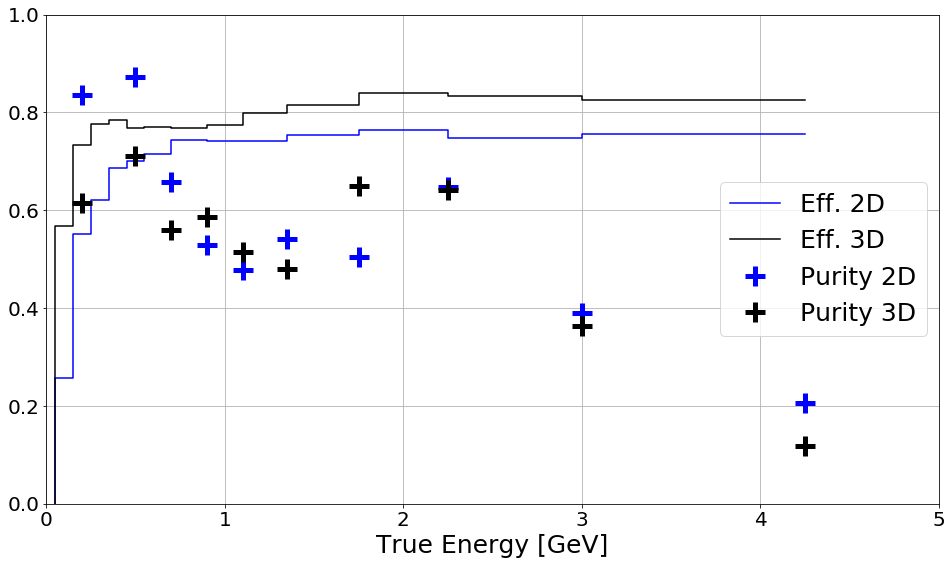

In [86]:
# Plot the efficiencies and purities
bin_centers = 0.5*(bins[1:] + bins[0:-1])
bin_widths =  bins[1:] - bins[:-1]

bin_centers_high_res = 0.5*(bins_high_res[1:] + bins_high_res[0:-1])
bin_widths_high_res =  bins_high_res[1:] - bins_high_res[:-1]

fig = plt.figure(figsize=(16.,9))
plt.grid(True)

plt.plot(bin_centers_high_res, efficiency_2d, label="Eff. 2D", color='blue',ls='steps')
plt.plot(bin_centers_high_res, efficiency_3d, label="Eff. 3D",color='black',ls='steps')
plt.plot(bin_centers, purity_2d, label="Purity 2D", color='blue',ls='--',marker='+',ms=20,mew=5,lw=0)
plt.plot(bin_centers, purity_3d, label="Purity 3D",color='black',ls='--',marker='+',ms=20,mew=5,lw=0)

plt.xlabel("True Energy [GeV]", fontsize=25)

plt.xlim(0,5)

ax = plt.gca()
ax.set_axisbelow(True)
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(20)

plt.ylim(0,1)

plt.legend(fontsize=25)
plt.savefig("nue_inclusive_purity50_comparison.png")
plt.show()


## CCQE Like Selection

Here, repeat the previous steps but require the selection of a single proton, and nothing else, at the vertex.

In [26]:
def compute_purity_and_eff_2d_3d_multi_cut(df, 
                                 true_signal_selection, 
                                 selection_2d_template, 
                                 selection_3d_template, 
                                 cut_values):

    eff_2d = []
    purity_2d = []
    
    eff_3d = []
    purity_3d = []


    # Get the df of true events:
    true_events = df.query(true_signal_selection)

#     print "Number of true events: " + str(true_events.shape[0])
    
    for cut_value in cut_values:
        # We can ask the efficiency by selecting agains the true events
        # We can find the purity by selecting against the full selection, and then comparing true selection

        selected_true_events_2d = true_events.query(selection_2d_template.format(*cut_value))
            
#         print "Number of events selected by 2D: " + str(selected_true_events_2d.shape[0])
            
        # The total efficiency is the number of selected true events divided by the total number of true events
        n_selected_2d = selected_true_events_2d.shape[0]
        n_true_2d = true_events.shape[0]
    
#         print "2D Efficiency: " + str(1.0 * n_selected_2d / n_true_2d)
    
        eff_2d.append(1.0 * n_selected_2d / n_true_2d)
    

        selected_true_events_3d = true_events.query(selection_3d_template.format(*cut_value))
            
#         print "Number of events selected by 3D: " + str(selected_true_events_3d.shape[0])

        # The total efficiency is the number of selected true events divided by the total number of true events
        n_selected_3d = selected_true_events_3d.shape[0]
        n_true_3d = true_events.shape[0]
    
        eff_3d.append(1.0 * n_selected_3d / n_true_3d)
    
#         print "3D Efficiency: " + str(1.0 * n_selected_3d / n_true_3d)
    
        # Compute the purity by asking for all selected events, and then seeing how many of those are true
        selected_events_2d = df.query(selection_2d_template.format(*cut_value))
            
        selected_events_3d = df.query(selection_3d_template.format(*cut_value))
            
        n_selected_events_2d = selected_events_2d['weight'].sum()
        n_selected_events_3d = selected_events_3d['weight'].sum()
        
#         print "N Selected Events 2d: " + str(n_selected_events_2d)
#         print "N Selected Events 3d: " + str(n_selected_events_3d)
        
        n_true_selected_2d = selected_events_2d.query(true_signal_selection)['weight'].sum()
        n_true_selected_3d = selected_events_3d.query(true_signal_selection)['weight'].sum()

        if n_true_selected_2d != 0:
            purity_2d.append(1.0 * n_true_selected_2d / n_selected_events_2d)
        else:
            purity_2d.append(0)

        if n_true_selected_3d != 0:
            purity_3d.append(1.0 * n_true_selected_3d / n_selected_events_3d)
        else:
            purity_3d.append(0)
    

    return eff_2d, eff_3d, purity_2d, purity_3d
    

In [25]:
true_signal_selection = "neut == 0 & prot==1 & chrpi==0 & neutpi==0"
selection_2d_template = "nue_score2d >= {} & prot1_score2d >= {} & ntpi0_score2d >= {} & chpi0_score2d >= {}"
selection_3d_template = "nue_score3d >= {} & prot1_score3d >= {} & ntpi0_score3d >= {} & chpi0_score3d >= {}"

# cut_values = numpy.concatenate( (numpy.linspace(0.0, 0.99, 10),  numpy.geomspace(0.99, 0.999999, 10)) )
# cut_values = 
# This is not doing any marginalization:
cut_values = [(x, x, x, x) for x in numpy.linspace(0,0.99, 100)]
cut_values_2 = [(x,x,x,x) for x in numpy.geomspace(0.99,0.99999, 100)]
cut_values = numpy.concatenate([cut_values,cut_values_2])
eff_2d, eff_3d, purity_2d, purity_3d = compute_purity_and_eff_2d_3d_multi_cut(df, 
                                                                    true_signal_selection, 
                                                                    selection_2d_template, 
                                                                    selection_3d_template, 
                                                                    cut_values)



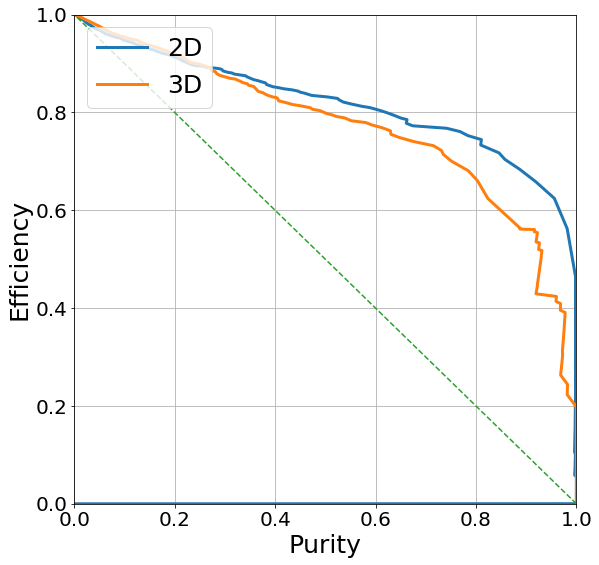

In [26]:

# Make the plot:
fig = plt.figure(figsize=(9,9))
plt.grid(True)
plt.plot(purity_2d,eff_2d,lw=3, label="2D")
plt.plot(purity_3d, eff_3d,lw=3, label="3D")
plt.plot([1,0], [0,1], ls='--')

plt.ylabel("Efficiency", fontsize=25)
plt.xlabel("Purity", fontsize=25)


plt.legend(fontsize=25, loc=2)

plt.xlim(0,1)
plt.ylim(0,1)
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(20)
plt.savefig("NueCC_SingleProton_ROC.png")

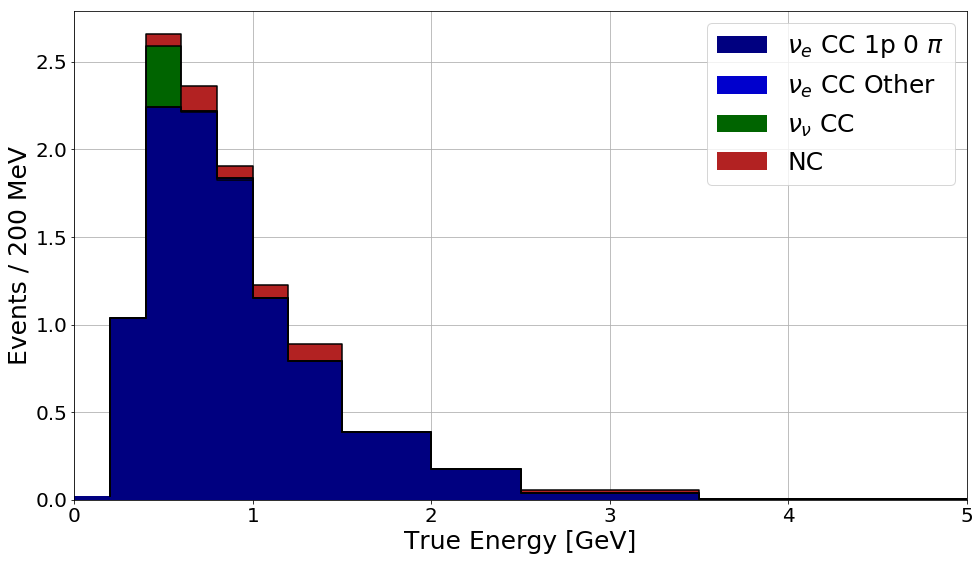

In [38]:
cuts_2d = "nue_score2d >= {} & prot1_score2d >= {} & ntpi0_score2d >= {} & chpi0_score2d >= {}".format(
    0.95, 0.95, 0.95, 0.95)
selection = ['neut==0 & neutpi ==0 & chrpi==0 & prot==1',
             'neut==0 & prot != 1',
             'neut==1', 
             'neut==2',
            ]
labels = [r'$\nu_e$ CC 1p 0 $\pi$',
          r'$\nu_e$ CC Other',
          r'$\nu_\nu$ CC', 
          'NC',
         ]
colors = ['navy',
          'mediumblue',
          'darkgreen', 
#           'yellowgreen',
          'firebrick',
#           'pink',
         ]
selected_events_2d = df.query(cuts_2d)
plot_selected_events(selected_events_2d, selections=selection, labels=labels, colors=colors,savepath="NueCC_singleproton_distribution_2d.png")


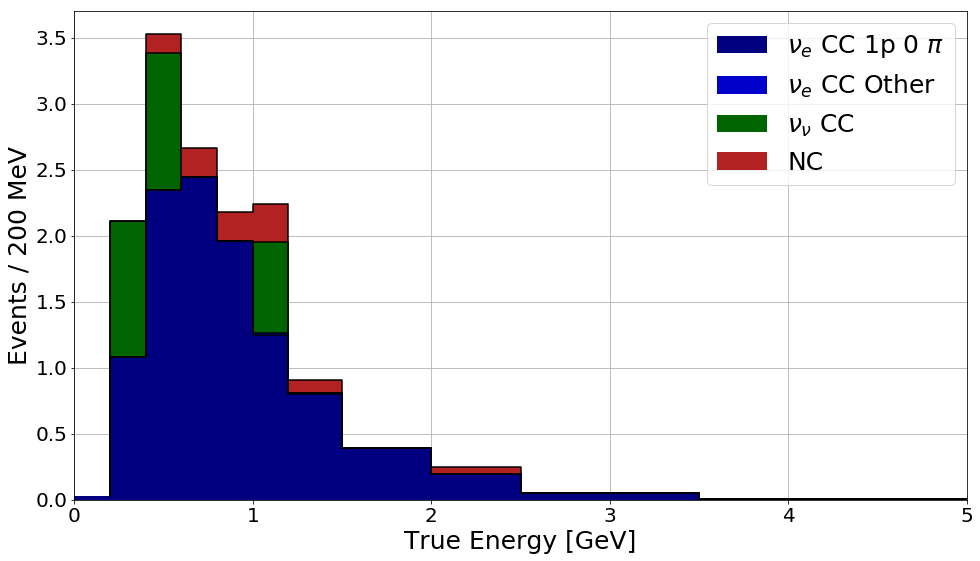

In [37]:
cuts_3d = "nue_score3d >= {} & prot1_score3d >= {} & ntpi0_score3d >= {} & chpi0_score3d >= {}".format(
    0.95, 0.95, 0.95, 0.95)
selection = ['neut==0 & neutpi ==0 & chrpi==0 & prot==1',
             'neut==0 & prot != 1',
             'neut==1', 
             'neut==2',
            ]
labels = [r'$\nu_e$ CC 1p 0 $\pi$',
          r'$\nu_e$ CC Other',
          r'$\nu_\nu$ CC', 
          'NC',
         ]
colors = ['navy',
          'mediumblue',
          'darkgreen', 
#           'yellowgreen',
          'firebrick',
#           'pink',
         ]
selected_events_3d = df.query(cuts_3d)
plot_selected_events(selected_events_3d, selections=selection, labels=labels, colors=colors, savepath="NueCC_singleproton_distribution_3d.png")


## Score Comparisions

In the above plots, it seems that 3D outperforms 2D well with aggressive cuts, and they are comparable with loose cuts.  To visualize this in a single plot, we can make a histogram of 2D score vs. 3D score for signal and background events.

First make some 1D histograms to show the relative distribution of scores:

In [29]:
bins = numpy.arange(-0.025,1.001, 0.0125)
nue_scores_2d, _ = numpy.histogram(df.query('neut==0')['nue_score2d'], bins=bins)
nue_scores_3d, _ = numpy.histogram(df.query('neut==0')['nue_score3d'], bins=bins)

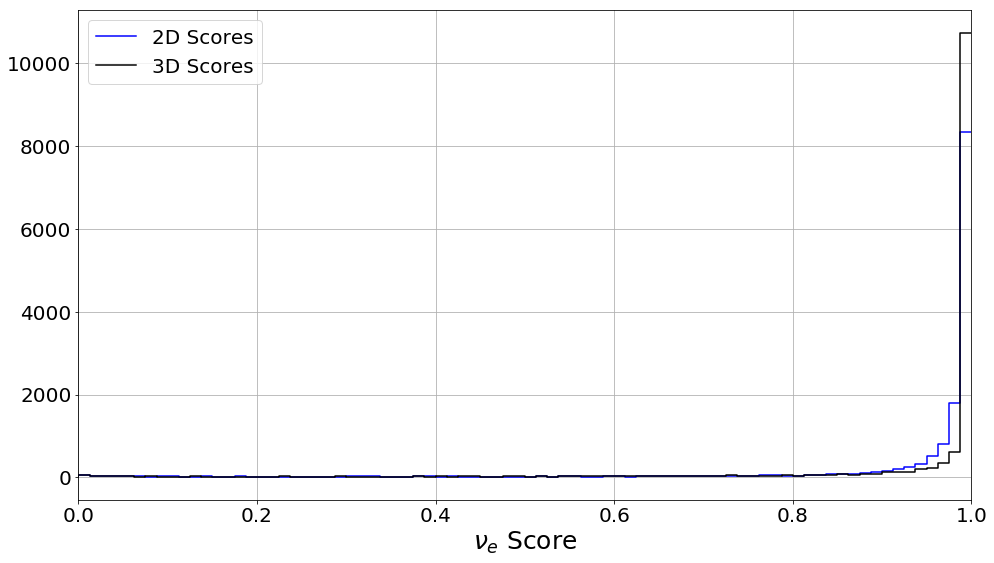

In [30]:
bin_centers = 0.5*(bins[1:] + bins[0:-1])
bin_widths =  bins[1:] - bins[:-1]

plt.figure(figsize=(16,9))
plt.grid(True)
plt.plot(bin_centers + bin_widths*0.5, nue_scores_2d, color='blue',
         ls='steps', label="2D Scores")
plt.plot(bin_centers + bin_widths*0.5, nue_scores_3d, color='black',
         ls='steps', label="3D Scores")

plt.xlim(0,1)
ax = plt.gca()
ax.set_axisbelow(True)
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(20)
plt.xlabel(r"$\nu_e$ Score", fontsize=25)
plt.legend(fontsize=20)

plt.show()

Since all of the scores pile up at high values, we'll make this a 2D log-log histogram

In [31]:
# bins = numpy.geomspace(0.65,1.0,50)
bins = numpy.arange(0.0,1.001,0.025)
print bins

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ]


In [32]:
nue_score_comparison, x_edges, y_edges = numpy.histogram2d(df.query('neut==0')['nue_score2d'],
                                                           df.query('neut==0')['nue_score3d'],
                                                           normed=False,
                                                           bins = bins)

In [33]:
print nue_score_comparison[-1]

[3.000e+00 3.000e+00 5.000e+00 8.000e+00 6.000e+00 6.000e+00 9.000e+00
 4.000e+00 6.000e+00 4.000e+00 6.000e+00 8.000e+00 5.000e+00 6.000e+00
 9.000e+00 8.000e+00 9.000e+00 1.500e+01 1.200e+01 1.000e+01 7.000e+00
 9.000e+00 1.500e+01 1.400e+01 1.800e+01 1.500e+01 1.900e+01 1.700e+01
 2.800e+01 2.600e+01 3.000e+01 3.300e+01 2.800e+01 5.100e+01 6.200e+01
 8.100e+01 1.270e+02 1.650e+02 2.960e+02 8.956e+03]


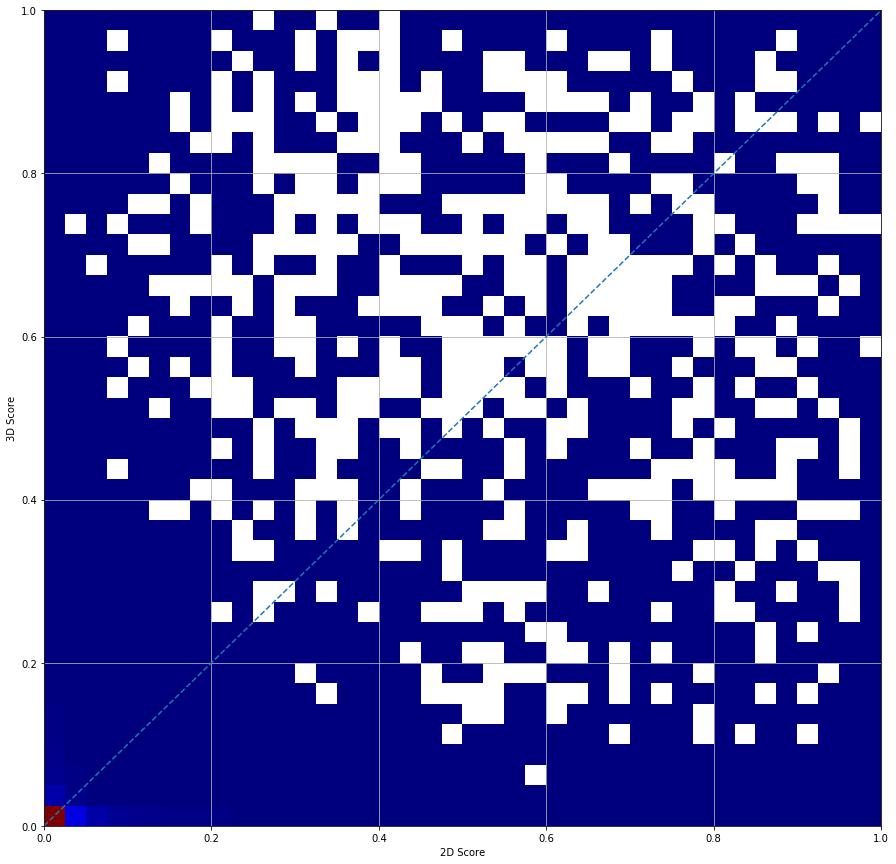

In [34]:
figure = plt.figure(figsize=(15,15))
cmap = plt.get_cmap('jet')
cmap.set_under('white')
plt.hist2d(df.query('neut==2')['nue_score2d'],
           df.query('neut==2')['nue_score3d'],
           normed=False,
           bins = bins,
           vmin=0.5,
           cmap=cmap)
plt.plot([0,1],[0,1],ls="--")
plt.grid(True)
ax.set_axisbelow(True)
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(30)
plt.xlabel("2D Score")
plt.ylabel("3D Score")
plt.show()

In [27]:
true_signal_selection = "neut == 2 & prot==1 & neutpi==1"
selection_2d_template = "nc_score2d >= {} & prot1_score2d >= {} & ntpi1_score2d >= {}"
selection_3d_template = "nc_score3d >= {} & prot1_score3d >= {} & ntpi1_score3d >= {}"

# cut_values = numpy.concatenate( (numpy.linspace(0.0, 0.99, 10),  numpy.geomspace(0.99, 0.999999, 10)) )
# cut_values = 
# This is not doing any marginalization:
cut_values = [(x, x, x) for x in numpy.linspace(0,0.99, 100)]
cut_values_2 = [(x,x,x) for x in numpy.geomspace(0.99,0.99999, 100)]
cut_values = numpy.concatenate([cut_values,cut_values_2])
eff_2d, eff_3d, purity_2d, purity_3d = compute_purity_and_eff_2d_3d_multi_cut(df, 
                                                                    true_signal_selection, 
                                                                    selection_2d_template, 
                                                                    selection_3d_template, 
                                                                    cut_values)



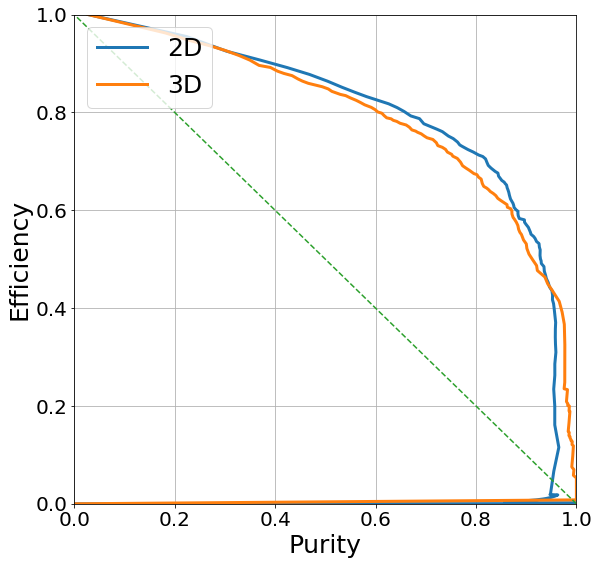

In [28]:

# Make the plot:
fig = plt.figure(figsize=(9,9))
plt.grid(True)
plt.plot(purity_2d,eff_2d,lw=3, label="2D")
plt.plot(purity_3d, eff_3d,lw=3, label="3D")
plt.plot([1,0], [0,1], ls='--')

plt.ylabel("Efficiency", fontsize=25)
plt.xlabel("Purity", fontsize=25)


plt.legend(fontsize=25, loc=2)

plt.xlim(0,1)
plt.ylim(0,1)
ax = plt.gca()
for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(20)
plt.savefig("ROC_nueCC_inclusive.png")

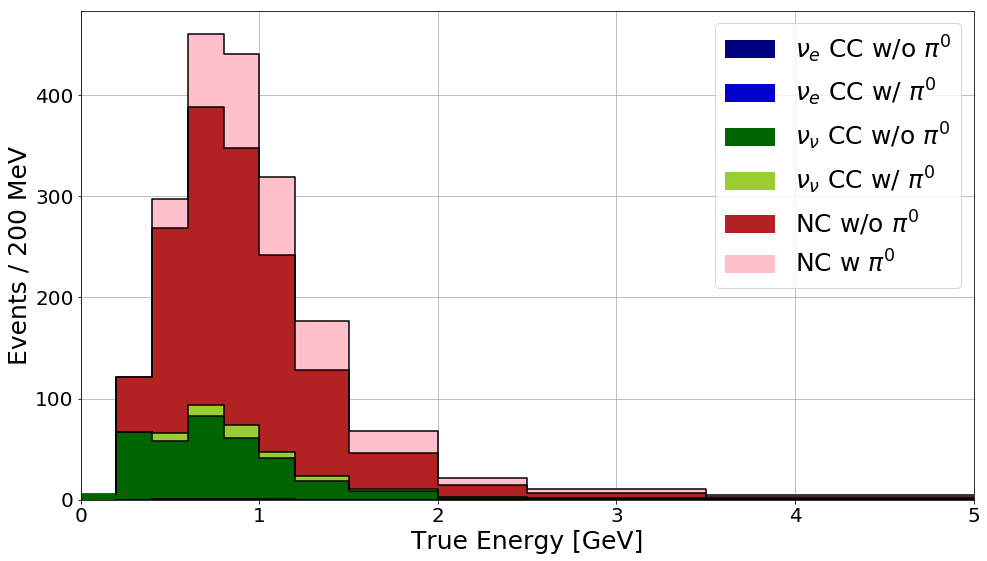

In [25]:
# cuts_2d = "nue_score2d>={}".format(0.99)
cuts_2d = "nc_score2d>={}".format(cut_values[purity_min_index_2d])
selected_events_2d = df.query(cuts_2d)
# Break things down further to test the plotting functionality:
selection = ['neut==0 & neutpi ==0',
             'neut==0 & neutpi ==1',
             'neut==1 & neutpi ==0', 
             'neut==1 & neutpi ==1', 
             'neut==2 & neutpi ==0',
             'neut==2 & neutpi ==1',
            ]
labels = [r'$\nu_e$ CC w/o $\pi^0$',
          r'$\nu_e$ CC w/ $\pi^0$',
          r'$\nu_\nu$ CC w/o $\pi^0$', 
          r'$\nu_\nu$ CC w/ $\pi^0$', 
          'NC w/o $\pi^0$',
          'NC w $\pi^0$',
         ]
colors = ['navy',
          'mediumblue',
          'darkgreen', 
          'yellowgreen',
          'firebrick',
          'pink',
         ]
plot_selected_events(selected_events_2d, selections=selection, labels=labels, colors=colors, savepath="nue_inclusive_2d.png")